In [1]:
!pip install gensim scikit-learn matplotlib pandas tensorflow


In [2]:
!pip install -U tensorflow==2.19.0


In [3]:
import pandas as pd
import numpy as np
import re
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding, Dropout


In [4]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:

df = pd.read_csv("/content/drive/MyDrive/Dataset.tsv", sep="\t")

df = df[df["label"].isin(["Positive", "Negative"])].reset_index(drop=True)

print(df["label"].value_counts())
df.head()


label
Positive    33333
Negative    33333
Name: count, dtype: int64


,label,text
0,Positive,ممتاز نوعا ما . النظافة والموقع والتجهيز والشا...
1,Positive,أحد أسباب نجاح الإمارات أن كل شخص في هذه الدول...
2,Positive,هادفة .. وقوية. تنقلك من صخب شوارع القاهرة الى...
3,Positive,خلصنا .. مبدئيا اللي مستني ابهار زي الفيل الاز...
4,Positive,ياسات جلوريا جزء لا يتجزأ من دبي . فندق متكامل...


In [6]:
def clean_text(text):
    text = str(text)
    text = re.sub(r"[\u0617-\u061A\u064B-\u0652]", "", text)
    text = re.sub(r"[إأٱآا]", "ا", text)
    text = re.sub(r"ى", "ي", text)
    text = re.sub(r"[ؤئ]", "ء", text)
    text = re.sub(r"ة", "ه", text)
    text = re.sub(r"[^0-9\u0600-\u06FF\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["text"] = df["text"].apply(clean_text)
df.head()


,label,text
0,Positive,ممتاز نوعا ما النظافه والموقع والتجهيز والشاطي...
1,Positive,احد اسباب نجاح الامارات ان كل شخص في هذه الدول...
2,Positive,هادفه وقويه تنقلك من صخب شوارع القاهره الي هدو...
3,Positive,خلصنا مبدءيا اللي مستني ابهار زي الفيل الازرق ...
4,Positive,ياسات جلوريا جزء لا يتجزا من دبي فندق متكامل ا...


In [7]:
sentences = [text.split() for text in df["text"]]

print("Example tokenized sentence:", sentences[0][:10])


Example tokenized sentence: ['ممتاز', 'نوعا', 'ما', 'النظافه', 'والموقع', 'والتجهيز', 'والشاطيء', 'المطعم']


In [8]:
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, sg=1)
w2v_model.save("word2vec.model")

print("Vocabulary size:", len(w2v_model.wv))


Vocabulary size: 238169


In [9]:
def get_sentence_vector(sentence):
    words = sentence.split()
    vec = np.zeros(100)
    count = 0
    for w in words:
        if w in w2v_model.wv:
            vec += w2v_model.wv[w]
            count += 1
    if count > 0:
        vec /= count
    return vec

X = np.array([get_sentence_vector(text) for text in df["text"]])


In [10]:
le = LabelEncoder()
y = le.fit_transform(df["label"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))


Training samples: 59999
Testing samples: 6667


In [11]:
model = Sequential()
model.add(Dense(128, input_shape=(100,), activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(64, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,249 (83.00 KB)

 Trainable params: 21,249 (83.00 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history = model.fit(
    X_train, y_train,
    epochs=8,
    batch_size=32,
    validation_data=(X_test, y_test)
)


Epoch 1/8
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.7206 - loss: 0.5402 - val_accuracy: 0.8073 - val_loss: 0.4268
Epoch 2/8
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7954 - loss: 0.4450 - val_accuracy: 0.8191 - val_loss: 0.4173
Epoch 3/8
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8013 - loss: 0.4336 - val_accuracy: 0.8163 - val_loss: 0.4036
Epoch 4/8
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8065 - loss: 0.4221 - val_accuracy: 0.8137 - val_loss: 0.4035
Epoch 5/8
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8068 - loss: 0.4196 - val_accuracy: 0.8179 - val_loss: 0.3987
Epoch 6/8
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8120 - loss: 0.4114 - val_accuracy: 0.8275 - val_loss: 0.3871
Epoch 7/8
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8135 - loss: 0.4085 - val_accuracy: 0.8283 - val_loss: 0.3877
Epoch 8/8
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8166 - loss: 0.4024 - val_acc

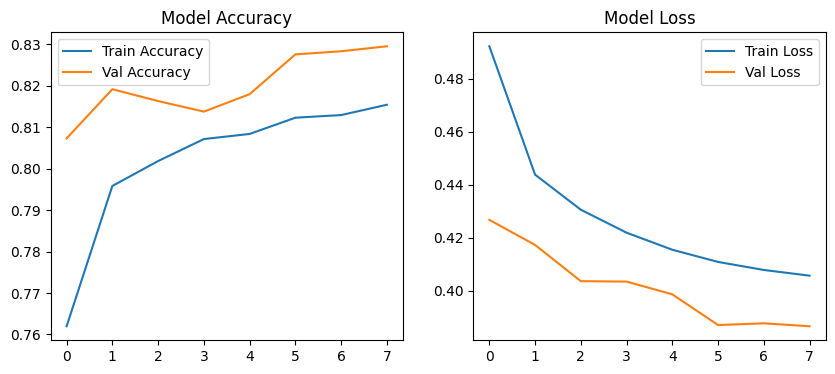

In [13]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.legend()
plt.title("Model Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Model Loss")

plt.show()


In [14]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")

print(classification_report(y_test, y_pred, target_names=le.classes_))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

    Negative       0.83      0.83      0.83      3334
    Positive       0.83      0.83      0.83      3333

    accuracy                           0.83      6667
   macro avg       0.83      0.83      0.83      6667
weighted avg       0.83      0.83      0.83      6667

Confusion Matrix:
 [[2755  579]
 [ 558 2775]]


In [16]:
samples = [
    "مش عاجبني المطعم الأكل وحش",
    "المكان شكله حلو أوي هاروح تاني",
    "المعاملة مش أحسن حاجة",
    "بجد شكرا جدا أنا اتبسطت"
]

sample_vecs = np.array([get_sentence_vector(clean_text(s)) for s in samples])
preds = (model.predict(sample_vecs) > 0.5).astype(int)

for s, p in zip(samples, preds):
    print(s, "->", le.inverse_transform(p)[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step
مش عاجبني المطعم الأكل وحش -> Negative
المكان شكله حلو أوي هاروح تاني -> Positive
المعاملة مش أحسن حاجة -> Negative
بجد شكرا جدا أنا اتبسطت -> Positive
